In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.mlab as mlab
from mpl_toolkits.mplot3d import Axes3D
from sklearn import mixture

from sklearn.preprocessing import StandardScaler
from sklearn.mixture import GaussianMixture

import itertools
from scipy import linalg
import matplotlib as mpl

%matplotlib inline

In [2]:
df = pd.read_csv('Torschlag_Trafo_07122015_to_11122015.csv', sep=',')

In [3]:
X = df[["V1","V2","V3","I1","I2","I3","Pges","Sges","CosPhi"]]

# Data Smoothing

In [4]:
r = X.rolling(60).mean()

In [5]:
data_smooth = pd.DataFrame(r.iloc[59:,:])

In [6]:
data_smooth.shape

(380589, 9)

(array([  4.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          0.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   2.00000000e+00,   0.00000000e+00,
          0.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   1.00000000e+00,   0.00000000e+00,
          1.00000000e+00,   0.00000000e+00,   1.00000000e+00,
          2.00000000e+00,   0.00000000e+00,   2.00000000e+00,
          3.00000000e+00,   6.00000000e+00,   1.50000000e+01,
          1.00000000e+01,   8.00000000e+00,   7.00000000e+00,
          5.00000000e+00,   8.00000000e+00,   8.00000000e+00,
          6.00000000e+00,   7.00000000e+00,   6.00000000e+00,
          4.00000000e+00,   1.00000000e+01,   1.10000000e+01,
        

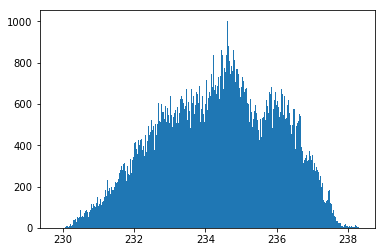

In [7]:
plt.hist(data_smooth.iloc[:,0],bins=1000)

# End of Data Smoothing

In [8]:
#PCA Implementation
from sklearn.preprocessing import StandardScaler
X_std = StandardScaler().fit_transform(data_smooth)

X_non_smoothed = StandardScaler().fit_transform(X)

([array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
            274.,   7063.,  25575.,  52421.,  66664.,  81322.,  68273.,
          58455.,  20003.,    598.,      0.,      0.,      0.]),
  array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
            284.,   6547.,  26714.,  50590.,  68179.,  84286.,  63096.,
          59434.,  20971.,    547.,      0.,      0.,      0.]),
  array([     0.,      0.,      0.,      0.,      0.,      0.,      0.,
            369.,   6997.,  26014.,  51096.,  67909.,  81061.,  69794.,
          56255.,  20511.,    642.,      0.,      0.,      0.]),
  array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   3.75300000e+03,   2.14683000e+05,
           3.84910000e+04,   4.44770000e+04,   4.23890000e+04,
           2.13250000e+04,   1.09860000e+04,   3.35800000e

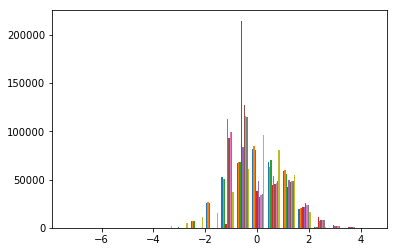

In [9]:
plt.hist(X_non_smoothed,bins=20)

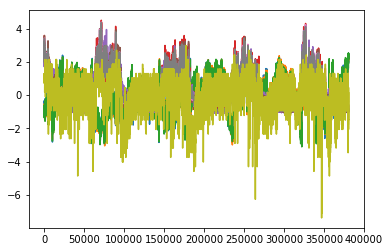

In [10]:
plt.plot(X_non_smoothed)

([array([  0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
           0.00000000e+00,   0.00000000e+00,   1.30000000e+01,
           1.00000000e+01,   1.16000000e+02,   2.87000000e+02,
           7.08000000e+02,   1.03500000e+03,   1.15300000e+03,
           1.41600000e+03,   2.06800000e+03,   1.91300000e+03,
           2.94300000e+03,   2.93800000e+03,   3.60000000e+03,
           4.70100000e+03,   4.61300000e+03,   4.82400000e+03,
           6.45800000e+03,   6.47500000e+03,   6.53100000e+03,
           7.54000000e+03,   7.44700000e+03,   8.96700000e+03,
           8.97800000e+03,   8.86400000e+03,   8.79900000e+03,
           9.24400000e+03,   9.99300000e+03,   9.52800000e+03,
           9.66200000e+03,   9.56100000e+03,   9.643000

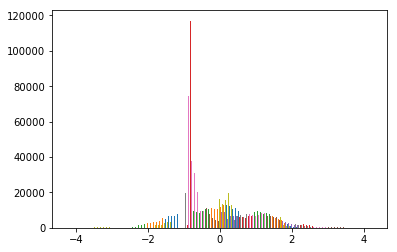

In [19]:
plt.hist(X_std,bins=100)

In [12]:
X_std[1000]

array([-0.81479743, -0.91980114, -0.94375773,  0.81415447,  1.01030995,
        1.22427872,  1.08495911,  1.03381005,  1.29075557])

In [13]:
#Calculate the z-score of all the points
from scipy import stats
zscore = stats.zscore(X)

{'boxes': [<matplotlib.lines.Line2D at 0x7f609310b710>,
 'caps': [<matplotlib.lines.Line2D at 0x7f6093098650>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f60930a3950>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f60930a3310>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f609310b8d0>,
  <matplotlib.lines.Line2D at 0x7f6092ff7d10>]}

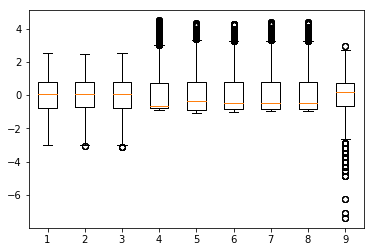

In [14]:
plt.boxplot(zscore)

In [15]:
from sklearn.decomposition import PCA 
sklearn_pca = PCA(n_components=9)
Y_sklearn = sklearn_pca.fit_transform(X_std)



In [16]:
#Convert the PCA to dataframe
data = pd.DataFrame(Y_sklearn, columns=('PCA1', 'PCA2','PCA3','PCA4','PCA5','PCA6','PCA7','PCA8','PCA9'))
data.head()



,PCA1,PCA2,PCA3,PCA4,PCA5,PCA6,PCA7,PCA8,PCA9
0,6.478272,-2.004349,0.832634,0.325690,0.166163,0.112744,-0.043534,-0.007617,0.004075
1,6.482626,-2.000501,0.826960,0.326404,0.167152,0.113730,-0.043292,-0.007664,0.004168
2,6.483993,-1.996518,0.826020,0.326317,0.167874,0.115169,-0.043085,-0.007563,0.004180
3,6.485360,-1.992535,0.825080,0.326229,0.168596,0.116608,-0.042879,-0.007461,0.004193
4,6.486727,-1.988552,0.824139,0.326142,0.169317,0.118046,-0.042672,-0.007359,0.004205


/home/arun/anaconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


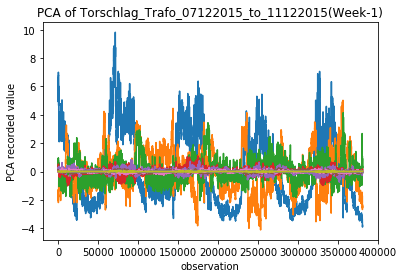

In [17]:
#Plot the PCA values
fig = plt.figure() 
plt.legend(loc='upper right')
plt.plot(data)
plt.title("PCA of Torschlag_Trafo_07122015_to_11122015(Week-1)")

#plt.legend()
plt.ylabel("PCA recorded value")
plt.xlabel("observation")

In [18]:
#Fit GMM on the PCA
from sklearn.mixture import GaussianMixture
import pylab as pl

n_components = np.arange(1, 200)
BIC = np.zeros(n_components.shape)
AIC = np.zeros(n_components.shape)
for i, n in enumerate(n_components):
    clf = GaussianMixture(n_components=n,
              covariance_type='full')
    clf.fit(data)

    AIC[i] = clf.aic(data)
    BIC[i] = clf.bic(data)
    
pl.figure()
pl.plot(n_components, AIC, label='AIC')
pl.plot(n_components, BIC, label='BIC')
pl.legend(loc=0)
pl.xlabel('n_components')
pl.ylabel('AIC / BIC')

KeyboardInterrupt: 

In [ ]:
clf.weights_.shape #the weights of no_of_components, see first parameter to GaussianMixture

In [ ]:
clf.means_.shape #(n_components, n_features)

In [ ]:
clf.covariances_.shape #(n_components, n_features, n_features) if 'full'

The precision matrices for each component in the mixture. **A precision matrix is the inverse of a covariance matrix.** A covariance matrix is symmetric positive definite so the mixture of Gaussian can be equivalently parameterized by the precision matrices. Storing the precision matrices instead of the covariance matrices makes it more efficient to compute the log-likelihood of new samples at test time. The shape depends on covariance_type:

In [ ]:
clf.precisions_.shape #

In [ ]:
data.shape

In [ ]:
plt.scatter(clf.precisions_, clf.covariances_)
plt.title('Scatter plot of precisions and covariances')

In [ ]:
Y = clf.sample(1000)


In [ ]:
classes = clf.predict(data)
classes

In [ ]:
classes = clf.predict(data)
plt.scatter(data.iloc[:,0], data.iloc[:,1], c=classes)
plt.legend()
plt.title('Scatterplot of predicted data')
plt.show()

In [ ]:
score_samp = clf.score_samples(Y_sklearn) #Compute the weighted log probabilities for each sample.

In [ ]:
score_samp.shape

In [ ]:
print("Score sample values:")
print("Min value : %s " % score_samp.min())
print("Max value : %s " % score_samp.max())
print("Mean value : %s " % score_samp.mean())
print("Median value : %s " % np.median(score_samp))
print("Standard Deviation value : %s " % score_samp.std())

In [ ]:
pdf = np.exp(score_samp)
pdf.shape

In [ ]:
print("Score sample values:")
print("Min value : %s " % pdf.min())
print("Max value : %s " % pdf.max())
print("Mean value : %s " % pdf.mean())
print("Median value : %s " % np.median(pdf))
print("Standard Deviation value : %s " % pdf.std())

In [ ]:
def gmm_ad(wgt_log_probability):
    values = []
    threshold = 3 * wgt_log_probability.std() #Cannot consider since its not a normal distribution
    a = np.absolute(wgt_log_probability.mean()) + threshold
    count = 0
    for i in range(0,len(wgt_log_probability)):
        #print i
        if np.absolute(wgt_log_probability[i]) > a:
            count = count + 1
            values.append(wgt_log_probability[i])
    return count, values
    #print values

In [ ]:
no_of_anomalies, wgt_log_prob = gmm_ad(score_samp)

In [ ]:
no_of_anomalies

In [ ]:
no_of_anomalies_pdf, wgt_log_prob_pdf = gmm_ad(pdf)

In [ ]:
no_of_anomalies_pdf

In [ ]:
wgt_log_prob[0:5]

In [ ]:
plt.hist(score_samp,bins=1000)

In [ ]:
plt.hist(pdf,bins=5)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from sklearn import mixture

n_samples = 300

# generate random sample, two components
np.random.seed(0)

# generate spherical data centered on (20, 20)
shifted_gaussian = np.random.randn(n_samples, 2) + np.array([20, 20])

# generate zero centered stretched Gaussian data
C = np.array([[0., -0.7], [3.5, .7]])
stretched_gaussian = np.dot(np.random.randn(n_samples, 2), C)

# concatenate the two datasets into the final training set
X_train = np.vstack([shifted_gaussian, stretched_gaussian])

# fit a Gaussian Mixture Model with two components
clf = mixture.GaussianMixture(n_components=2, covariance_type='full')
clf.fit(X_train)

# display predicted scores by the model as a contour plot
x = np.linspace(-20., 30.)
y = np.linspace(-20., 40.)
X, Y = np.meshgrid(x, y)
XX = np.array([X.ravel(), Y.ravel()]).T
Z = -clf.score_samples(XX)
Z = Z.reshape(X.shape)

CS = plt.contour(X, Y, Z, norm=LogNorm(vmin=1.0, vmax=1000.0),
                 levels=np.logspace(0, 3, 10))
CB = plt.colorbar(CS, shrink=0.8, extend='both')
plt.scatter(X_train[:, 0], X_train[:, 1], .8)

plt.title('Negative log-likelihood predicted by a GMM')
plt.axis('tight')
plt.show()

In [ ]:
def feature_normalize(dataset):
    mu = np.mean(dataset,axis=0)
    sigma = np.std(dataset,axis=0)
    return (dataset - mu)/sigma

In [ ]:
def estimateGaussian(dataset):
    mu = np.mean(dataset, axis=0)
    sigma = np.cov(dataset.T)
    return mu, sigma

In [ ]:
from scipy.stats import multivariate_normal

def multivariateGaussian(dataset,mu,sigma):
    p = multivariate_normal(mean=mu, cov=sigma)
    return p.pdf(dataset)

In [ ]:
mu, sigma = estimateGaussian(X)
p = multivariateGaussian(X,mu,sigma)